# Snapchat Filters

Import required packages

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

Read data files

In [0]:
training = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

In [5]:
training.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [6]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [7]:
train_nonull = training[training.isna().sum(axis=1) < 1]
print("Non null rows: ", len(train_nonull))

Non null rows:  2140


Prepare data

In [0]:
train_images = []
train_points = []

for i in range(len(train_nonull)):
    point = train_nonull.iloc[i, :-1]
    point = point/96 - 0.5
    train_points.append(point)
    
    img = np.array(train_nonull.iloc[i, -1].split(' '), dtype=np.int)
    img = img.reshape(96,96)/255
    train_images.append(img) 

train_images = np.array(train_images)
train_points = np.array(train_points)

In [9]:
print(train_images.shape)
print(train_points.shape)

(2140, 96, 96)
(2140, 30)


In [10]:
imgs_test = []
for i in range(len(test)):
    test_image = test.iloc[i,-1]        
    test_image = np.array(test_image.split(' ')).astype(int)
    test_image = np.reshape(test_image, (96,96))   
    test_image = test_image/255
    imgs_test.append(test_image)
    
imgs_test = np.array(imgs_test)
print(imgs_test.shape)

(1783, 96, 96)


Check data 

In [0]:
def plot_point_img(img, points):
    plt.imshow(img.reshape(96,96))
    for i in range(0,len(points), 2):
        plt.plot((points[i] + 0.5)*96, (points[i + 1] + 0.5)*96, 'rx')

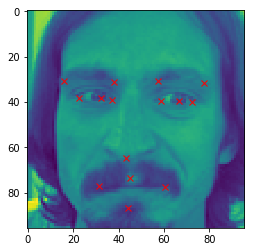

In [12]:
idx = 4
plot_point_img(train_images[idx], train_points[idx])

Add mirrored images to train data

In [0]:
def augment(img, points):
    f_img = img[:, ::-1]
    pts = points.copy()
    for i in range(0,len(pts),2):
        x_renorm = (points[i]+0.5)*96      
        dx = x_renorm - 48          
        x_renorm_flipped = x_renorm - 2*dx      
        pts[i] = x_renorm_flipped/96 - 0.5
    return f_img, pts

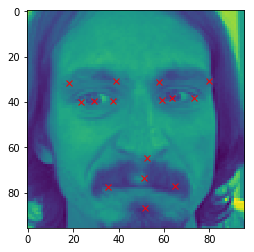

In [14]:
f_img, pts = augment(train_images[idx], train_points[idx])
plot_point_img(f_img, pts)

In [0]:
aug_imgs_train = []
aug_points_train = []

for i in range(len(train_images)):
    f_img, f_points = augment(train_images[i], train_points[i])
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
    
aug_imgs_train = np.array(aug_imgs_train)
aug_points_train = np.array(aug_points_train)

Combine mirrored and normal images

In [0]:
imgs_total = np.concatenate((train_images, aug_imgs_train), axis=0)
points_total = np.concatenate((train_points, aug_points_train), axis=0)

## Prepare model

In [0]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(96,96,1), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(30))
    
    model.summary()
    return model

In [18]:
model = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxP

In [19]:
!mkdir weights

mkdir: cannot create directory ‘weights’: File exists


In [21]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights/checkpoint-{epoch:02d}.hdf5')

imgs_total = imgs_total.reshape([-1, 96, 96, 1])

model.fit(imgs_total, points_total, epochs=300, batch_size=100, callbacks=[checkpoint])

Epoch 1/300
4280/4280 [==============================] - 25s 6ms/sample - loss: 0.1025 - acc: 0.5530
Epoch 2/300
4280/4280 [==============================] - 25s 6ms/sample - loss: 0.0954 - acc: 0.6757
Epoch 3/300
4280/4280 [==============================] - 25s 6ms/sample - loss: 0.0943 - acc: 0.6822
Epoch 4/300
4280/4280 [==============================] - 24s 6ms/sample - loss: 0.0935 - acc: 0.6827
Epoch 5/300
4280/4280 [==============================] - 25s 6ms/sample - loss: 0.0864 - acc: 0.6792
Epoch 6/300
4280/4280 [==============================] - 25s 6ms/sample - loss: 0.0672 - acc: 0.6376
Epoch 7/300
4280/4280 [==============================] - 25s 6ms/sample - loss: 0.0581 - acc: 0.6453
Epoch 8/300
4280/4280 [==============================] - 25s 6ms/sample - loss: 0.0532 - acc: 0.6402
Epoch 9/300
4280/4280 [==============================] - 25s 6ms/sample - loss: 0.0505 - acc: 0.6416
Epoch 10/300
4280/4280 [==============================] - 24s 6ms/sample - loss: 0.0511 - a

## Check model

In [22]:
model = get_model()
model.load_weights("weights/checkpoint-300.hdf5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 128)         147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 64)          8256      
__________

In [0]:
imgs_test = imgs_test.reshape((-1,96,96,1))

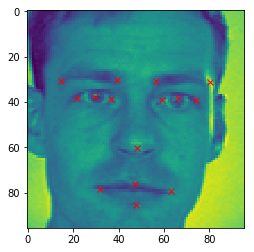

In [24]:
idx = 30
img = imgs_test[idx:idx+1]
point = model.predict(img)

plot_point_img(img[0], point[0])

(540, 960, 3)


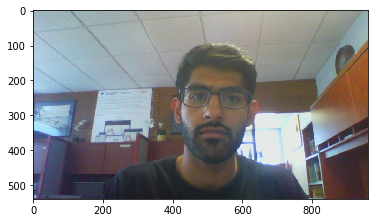

In [39]:
img = cv2.imread("2019-06-11-151707.jpg")

b,g,r = cv2.split(img)           
img_rgb = cv2.merge([r,g,b])

print(img_rgb.shape)
plt.imshow(img_rgb)

(540, 960)


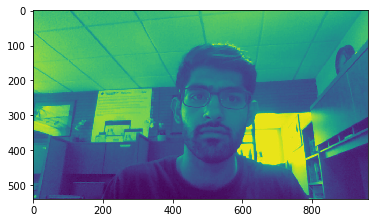

In [40]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray)

In [41]:
face_cascade = cv2.CascadeClassifier('haar.xml')
faces = face_cascade.detectMultiScale(gray,1.3,5)
faces

array([[392, 154, 255, 255]], dtype=int32)

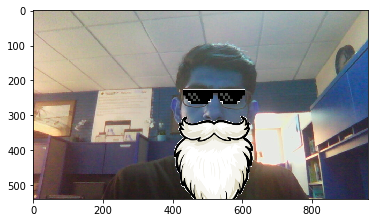

In [42]:
for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    img_copy = np.copy(img)
    img_copy_1 = np.copy(img)
    roi_color = img_copy_1[y:y+h, x:x+w]
    
#     print(roi_gray.shape)
#     plt.imshow(roi_gray)
    
    width_original = roi_gray.shape[1]   
    height_original = roi_gray.shape[0]  
    
    img_gray = cv2.resize(roi_gray, (96, 96))   
    img_gray = img_gray/255
        
    img_model = np.reshape(img_gray, (1,96,96,1)) 
    keypoints = model.predict(img_model)[0] 
    
#     plot_point_img(img_model[0], keypoints)
    
    x_coords = keypoints[0::2]
    y_coords = keypoints[1::2]

    x_coords_denormalized = (x_coords+0.5)*width_original 
    y_coords_denormalized = (y_coords+0.5)*height_original 

    for i in range(len(x_coords)):  
        cv2.circle(roi_color, (x_coords_denormalized[i], y_coords_denormalized[i]), 2, (255,255,0), -1)

    left_lip_coords = (int(x_coords_denormalized[11]), int(y_coords_denormalized[11]))
    right_lip_coords = (int(x_coords_denormalized[12]), int(y_coords_denormalized[12]))
    top_lip_coords = (int(x_coords_denormalized[13]), int(y_coords_denormalized[13]))
    bottom_lip_coords = (int(x_coords_denormalized[14]), int(y_coords_denormalized[14]))
    left_eye_coords = (int(x_coords_denormalized[3]), int(y_coords_denormalized[3]))
    right_eye_coords = (int(x_coords_denormalized[5]), int(y_coords_denormalized[5]))
    brow_coords = (int(x_coords_denormalized[6]), int(y_coords_denormalized[6]))

    beard_width = right_lip_coords[0] - left_lip_coords[0]
    glasses_width = right_eye_coords[0] - left_eye_coords[0]
    
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2BGRA)      
    
    # santa
    santa_filter = cv2.imread('beard.png', -1)
    (h_santa, w_santa) = santa_filter.shape[:2]
    width_santa = beard_width*3
    r_santa = width_santa / float(w_santa)
    dim = (width_santa, int(h_santa * r_santa))
    
#     santa_filter = cv2.resize(santa_filter, (beard_width*3,150))
    santa_filter = cv2.resize(santa_filter, dim)
    sw,sh,sc = santa_filter.shape
    
    beard_centre_x = left_lip_coords[0] + x + beard_width/2
    beard_centre_y = y+ (left_lip_coords[1] + right_lip_coords[1])/2
    
    beard_up = 0.2 * height_original
    
    sw_changed = sw
    if int(beard_centre_y - beard_up)+sw > img_copy.shape[0]:
        sw_changed = img_copy.shape[0] - int(beard_centre_y - beard_up)
    
    sh_changed = sh
    if int(beard_centre_x - 0.5 * sh) + sh > img_copy.shape[1]:
        sh_changed = img_copy.shape[1] - int(beard_centre_x - 0.5 * sh)
    
    
    for i in range(0,sw_changed):
        for j in range(0,sh_changed):
            if santa_filter[i,j][3] != 0:
#                 img_copy[top_lip_coords[1]+i+y-20, left_lip_coords[0]+j+x-60] = santa_filter[i,j]
                 img_copy[int(beard_centre_y - beard_up) + i, int(beard_centre_x - 0.5 * sh) + j] = santa_filter[i,j]
    
    
    #specs
    specs_filter = cv2.imread('specs.png', -1)
    (h_specs, w_specs) = santa_filter.shape[:2]
    width_specs = int(glasses_width*1.4)
    r_specs= width_specs / float(w_specs)
    dim = (width_specs, int(h_specs * r_specs) -60)
    dim = (width_specs, 120)

    
    specs_filter = cv2.resize(specs_filter, dim)
    gw,gh,gc = specs_filter.shape
    
    glass_centre_x = x + left_eye_coords[0] + glasses_width/2
    glass_centre_y = y + (left_eye_coords[1] + right_eye_coords[1])/2

    glass_up = 60
    
    for i in range(0,gw):
        for j in range(0,gh):
            if specs_filter[i,j][3] != 0:
#                 img_copy[top_lip_coords[1]+i+y-20, left_lip_coords[0]+j+x-60] = santa_filter[i,j]
                 img_copy[int(glass_centre_y - glass_up) + i, int(glass_centre_x - 0.5 * gh) + j] = specs_filter[i,j]
    
    
    
    
    plt.imshow(img_copy)
#     plt.plot(x+left_eye_coords[0], y+left_eye_coords[1], 'bx')
#     plt.plot(x+right_eye_coords[0], y+right_eye_coords[1], 'bx')
#     plt.plot(glass_centre_x, glass_centre_y, 'rx')

In [43]:
cv2.imwrite("out.jpg", img_copy)

True